In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns

**Data pre-processing**

Examine:
- the time between requests
- number of requests
- divide data into smaller intervals
- check number of tokens within a 5-minute time frame
- number of requests in a row

In [3]:
#Code for creating data frame of testing data
data = pd.read_csv('requests.csv')
data.columns = ['timestamp', 'userID', 'sessionID', 'expiring', 'URL']
data

,timestamp,userID,sessionID,expiring,URL
0,1676373343936,user-1003,c85cbd00-d2fc-4cda-9f5c-66616847d851,1676373495816,/chat/send/442
1,1676373344344,user-1005,a0038f81-b46a-4f26-a7ea-2791d53404fb,1676373476316,/profile/407
2,1676373344456,user-1003,c85cbd00-d2fc-4cda-9f5c-66616847d851,1676373495816,/chat/send/969
3,1676373344912,user-65,fd48a9f9-67f4-4185-9bcc-a76b7139401c,1676373604676,/searchUsers?page=0
4,1676373345020,user-1005,a0038f81-b46a-4f26-a7ea-2791d53404fb,1676373476316,/profile/148
...,...,...,...,...,...
263206,1676444990852,user-629,2a43fe7f-d300-470d-9523-d362b70b37d3,1676445248826,/profile/572
263207,1676444991104,user-629,2a43fe7f-d300-470d-9523-d362b70b37d3,1676445248826,/conversation/572
263208,1676444991342,user-629,2a43fe7f-d300-470d-9523-d362b70b37d3,1676445248826,/conversation/572/markAsRead
263209,1676444991375,user-1005,0e84ab80-bfa4-402b-9ae0-6397441e91d6,1676445040536,/profile/995


In [4]:
#Formatting the data frame so that each row represent one user. 
#All requests are saved as a string in the "URL"-column
users = list(data['userID'])
allUsers = data.set_index(['userID']).rename_axis(None)
allUsers = allUsers.drop(columns=['timestamp', 'sessionID', 'expiring'])
df = allUsers.groupby(level=0).agg(','.join)
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'users'})



In [5]:
#Removing all non-letter characters from the data and assigning it to new data frame 'df_cleaned'
df_cleaned = df
request_logs = df_cleaned['URL']

cleaned_logs = []

for i in range(0, len(request_logs)):
    sequence = re.sub('[^a-zA-Z]', ' ', request_logs[i])
    sequence = sequence.lower()
    cleaned_logs.append(sequence)

df_cleaned ['request_logs'] = cleaned_logs
df_cleaned = df_cleaned.drop('URL', axis=1)

# 5 and 6: spammers, 7: data scraper
#print(cleaned_logs[7])


In [6]:
#Using the tfidf-vectorizer
tfidf_vect = CountVectorizer()
#tfidf_vect = TfidfVectorizer()
vect_logs = tfidf_vect.fit_transform(df_cleaned['request_logs'])

In [46]:

"""
Code for calculating variance, might delete
arr_values = []
#arr_variance = []

for i in range(0,1):
    for j in range (0, vect_logs.shape[1]):
        #print(vect_logs[i,j])
        val = vect_logs[i,j]
        arr_values.append(val)
        
print(arr_values, '\n')

array = np.array(arr_values)
print(array, '\n')
print(np.var([arr_values]))
"""

"\nCode for calculating variance, might delete\narr_values = []\n#arr_variance = []\n\nfor i in range(0,1):\n    for j in range (0, vect_logs.shape[1]):\n        #print(vect_logs[i,j])\n        val = vect_logs[i,j]\n        arr_values.append(val)\n        \nprint(arr_values, '\n')\n\narray = np.array(arr_values)\nprint(array, '\n')\nprint(np.var([arr_values]))\n"

In [7]:
#Code for checking an instance's request_logs

vector_instance=vect_logs[2] 
df_vectorized = pd.DataFrame(vector_instance.T.todense(), index=tfidf_vect.get_feature_names_out(), columns=["tfidf"])
df_vectorized.sort_values(by=["tfidf"], ascending=False)


,tfidf
conversation,34
profile,26
page,20
markasread,17
chat,15
send,15
searchusers,11
inbox,9
login,7
block,4



Some annotations for later
variance normal user[0]: 0.030732589
variance normal user[1]: 0.040072223
variance spammer 1: 0.075907392
variance spammer 2: 0.075314139
variance data scraper: 0.25440979



In [8]:
df_tfidf_scores = pd.DataFrame(vect_logs.todense(), columns= tfidf_vect.get_feature_names_out())
users = df['users']
#df_complete = pd.concat([df, df_tfidf_scores], axis=1)
#df_complete = df_complete.drop('request_logs', axis=1)
#df_complete

#Tror att vi vill hålla dem separat så att vi bara har numeriska värden att köra in i modellen. Men nu finns det en korrekt indexerad lista på alla användare:)
#print(users)
df_tfidf_scores

,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig
0,2,15,1,30,4,0,7,15,18,0,25,3,14,15,1
1,0,13,0,34,2,1,5,17,11,1,23,1,9,13,0
2,4,15,2,34,9,2,7,17,20,2,26,2,11,15,2
3,0,16,2,30,1,1,7,15,9,1,33,4,8,16,2
4,1,9,0,32,1,1,6,16,12,1,25,3,11,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,2,27,6,52,3,6,14,26,26,6,60,3,23,27,6
1000,7,52,4,100,8,4,15,50,39,4,87,2,31,52,4
1001,1,8,1,32,3,2,6,16,13,2,23,0,10,8,1
1002,0,12,0,28,8,2,5,14,16,2,22,0,8,12,0


In [9]:
variance_columns = ['profile', 'config', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig']
df_tfidf_scores['var_reqs'] = df_tfidf_scores[variance_columns].apply(lambda row: row.var(), axis=1)


In [10]:
df_tfidf_scores

,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig,var_reqs
0,2,15,1,30,4,0,7,15,18,0,25,3,14,15,1,92.857143
1,0,13,0,34,2,1,5,17,11,1,23,1,9,13,0,101.380952
2,4,15,2,34,9,2,7,17,20,2,26,2,11,15,2,98.314286
3,0,16,2,30,1,1,7,15,9,1,33,4,8,16,2,110.380952
4,1,9,0,32,1,1,6,16,12,1,25,3,11,9,0,93.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,2,27,6,52,3,6,14,26,26,6,60,3,23,27,6,322.409524
1000,7,52,4,100,8,4,15,50,39,4,87,2,31,52,4,1022.828571
1001,1,8,1,32,3,2,6,16,13,2,23,0,10,8,1,85.971429
1002,0,12,0,28,8,2,5,14,16,2,22,0,8,12,0,75.685714


In [11]:
unique_reqs_columns = ['profile', 'config', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig']
unique_reqs = np.count_nonzero(df_tfidf_scores[unique_reqs_columns], axis=1)
df_tfidf_scores['unique_reqs'] = unique_reqs

In [12]:
#Code to join the df_cleaned with the tf-idf scores. Try this with Isolation forest if we need to
joined_df = pd.concat([df_cleaned, df_tfidf_scores], axis = 1)
joined_df

,users,request_logs,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig,var_reqs,unique_reqs
0,user-10,login searchusers page profile c...,2,15,1,30,4,0,7,15,18,0,25,3,14,15,1,92.857143,13
1,user-100,login searchusers page profile p...,0,13,0,34,2,1,5,17,11,1,23,1,9,13,0,101.380952,12
2,user-1000,login searchusers page profile c...,4,15,2,34,9,2,7,17,20,2,26,2,11,15,2,98.314286,15
3,user-1001,login searchusers page profile p...,0,16,2,30,1,1,7,15,9,1,33,4,8,16,2,110.380952,14
4,user-1002,login searchusers page profile c...,1,9,0,32,1,1,6,16,12,1,25,3,11,9,0,93.266667,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,user-995,login searchusers page profile p...,2,27,6,52,3,6,14,26,26,6,60,3,23,27,6,322.409524,15
1000,user-996,login searchusers page profile p...,7,52,4,100,8,4,15,50,39,4,87,2,31,52,4,1022.828571,15
1001,user-997,login searchusers page profile c...,1,8,1,32,3,2,6,16,13,2,23,0,10,8,1,85.971429,14
1002,user-998,login searchusers page profile p...,0,12,0,28,8,2,5,14,16,2,22,0,8,12,0,75.685714,11


**Isolation Forest**

In [32]:
df_anomaly = df_tfidf_scores

#all features as anomaly inputs
#anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'config', 'conversation', 'inbox', 'report', 'send', 'userconfig', 'like', 'login', 'markasread', 'photos', 'unique_reqs', 'var_reqs']

#selected features as anomaly inputs (most significant features fpr user 903 are removed)
#anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig', 'var_reqs', 'unique_reqs']

#only higher level features as inputs
anomaly_inputs = ['unique_reqs', 'var_reqs']

model_if = IsolationForest(contamination=0.002, random_state=42)
model_if.fit(df_anomaly[anomaly_inputs])

c:\Users\vhage\Documents\Skolarbete\Exjobb\request-analyzer-model\.venv\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.002, random_state=42)

In [33]:
df_anomaly['anomaly_score'] = model_if.decision_function(df_anomaly[anomaly_inputs])
df_anomaly['anomaly'] = model_if.predict(df_anomaly[anomaly_inputs])

#This dataframe will only include anomaly score and anomaly label
df_anomaly_score = df_anomaly.loc[:,['anomaly_score', 'anomaly']]
df_anomaly_score.loc[df_anomaly_score['anomaly']==-1] 

,anomaly_score,anomaly
5,-0.001777,-1
6,-0.000645,-1
7,-0.019517,-1


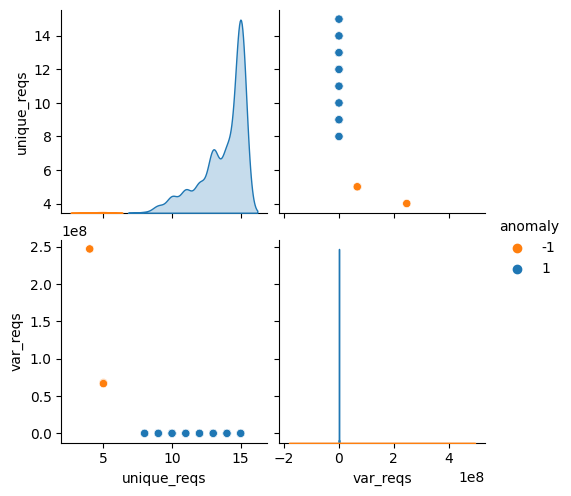

In [34]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_tfidf_scores, vars=anomaly_inputs, hue='anomaly', palette=palette)

**Testing out TSNE**

In [39]:
#Visualizing data with t-SNE
embedded_data = TSNE(perplexity=50.0, n_iter=2000).fit_transform(np.asarray(vect_logs.todense()))
spammer1 = embedded_data[5]
spammer2 = embedded_data[6]
dataScraper = embedded_data[7]

c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
plt.scatter(embedded_data[:,0], embedded_data[:,1])
plt.scatter(spammer1[0],spammer1[1], color='red')
plt.scatter(spammer2[0],spammer2[1], color='red')
plt.scatter(dataScraper[0],dataScraper[1], color='green')

**PCA: for dimension reduction**

In [ ]:
X = np.asarray(vect_logs.todense())
pca = PCA()
pc = pca.fit_transform(X)
pc = pd.DataFrame(pc)
print(pc.shape)
pc

(1004, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.014151,-0.056579,0.032928,-0.023269,0.055481,-0.034205,-0.040538,0.025775,-0.016518,0.009518,-1.280286e-16,-3.831713e-17,1.057929e-17,-2.338633e-18,-4.856402e-18
1,-0.004119,0.024946,-0.147911,-0.022661,0.028510,0.034089,-0.014530,0.004799,0.003663,-0.007788,-8.744214e-17,7.338508e-16,1.255754e-18,1.164123e-18,-1.868838e-18
2,-0.014892,-0.116458,-0.007735,0.021352,-0.046803,-0.034033,0.011968,0.011323,-0.003120,0.009117,-1.191586e-16,4.896034e-19,2.597761e-16,-8.735034e-18,5.820718e-19
3,0.053916,0.163665,-0.006286,0.058890,-0.023201,-0.003443,-0.069031,0.003830,0.044711,0.003305,-6.055011e-17,2.214700e-18,1.491026e-17,9.567101e-17,4.410390e-17
4,-0.117871,0.056486,-0.085556,-0.028776,0.044079,0.009919,-0.032389,0.033688,0.008695,0.033079,2.456695e-16,-6.957825e-18,1.102752e-18,4.682014e-18,-3.520608e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.003835,0.099379,0.097485,0.005731,-0.050682,0.024302,-0.019628,0.004157,-0.008210,-0.023072,-1.329339e-16,4.575345e-19,-3.629689e-18,-1.301168e-18,3.277074e-19
1000,0.065047,0.050680,-0.043768,0.016372,-0.001074,-0.001450,0.013162,0.007790,-0.017865,-0.020936,-1.153172e-16,-8.995457e-19,-4.964431e-20,1.634690e-19,-6.660678e-19
1001,-0.146306,-0.000804,-0.094498,-0.031923,-0.004844,0.033087,0.017118,-0.003498,0.002426,-0.018177,-9.874414e-17,1.573456e-18,4.964509e-19,1.209640e-18,-1.029603e-18
1002,-0.020214,-0.117290,-0.037662,0.069434,-0.017167,0.054558,0.004377,-0.023142,-0.014244,0.004660,-1.185357e-16,-5.354122e-19,-5.627769e-20,-2.431543e-18,2.037926e-18


In [ ]:
print("Eigen values: ", list(np.round(pca.explained_variance_, decimals=5)))
print("PCA_variance_ratio: ", pca.explained_variance_ratio_)
print(pca.n_components)

Eigen values:  [0.01488, 0.00659, 0.0065, 0.0027, 0.00165, 0.00096, 0.00072, 0.00067, 0.00064, 0.00044, 0.0, 0.0, 0.0, 0.0, 0.0]
PCA_variance_ratio:  [4.16085399e-01 1.84349822e-01 1.81923581e-01 7.55255767e-02
 4.62256577e-02 2.67749579e-02 2.01896368e-02 1.87541698e-02
 1.79152153e-02 1.22559840e-02 3.65468573e-31 1.53534692e-32
 1.92533169e-33 4.23884406e-34 1.60565512e-34]
None


Following code just serves as a way to experiment using sequence of numbers. Could we use tfidf for vectorizing data?

In [ ]:
#Function to create a sequence of numbers. Approx. 10% of the sequences will consist of duplicates of the same number
import random

def create_sequence(arr, randVal):
    if (randVal < 1):
        val = random.randint(1,9)
        for i in range (50):
            arr.append(val)
    else:    
        for i in range (0, 50):
            arr.append(random.randint(1,9))
    return arr    

In [ ]:
#Function to give a sequence a score depending on number of consecutive duplicates
def sequence_evaluation(df):
    arr = []
    for i in range (0, df.shape[0]):
        data = df.iloc[i].to_list()
        score = 0
        lr = 0.1
        val = data[0]
        for j in range (1, len(data)):
            if (data[j] == val):
                score -= lr*data[j]
                if(lr < 1):
                    lr += 1.1*lr
            else:
                score += data[j]
                val = data[j]
        arr.append(score) 
    return arr     

In [ ]:
#Function that calculates length of the longest subsequence of consecutive duplicates for each sequence
from itertools import groupby

def longestConsecutive(df):
    arr = []
    for i in range (0, df.shape[0]):
        longest_streak = len(max([list(group) for _, group in groupby(df.iloc[i].to_list())], key=len))
        arr.append(longest_streak)
    return arr

In [ ]:
#Creation of the sequence data frame
sequence_matrix = []
for i in range (1000):
    randVal = random.randint(0,9)
    arr = []
    sequence_matrix.append(create_sequence(arr, randVal))

sequence_df = pd.DataFrame(sequence_matrix)

sequence_df['score'] = sequence_evaluation(sequence_df)
sequence_df['longestConsec'] = longestConsecutive(sequence_df.loc[:, sequence_df.columns != 'score'])
sequence_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,score,longestConsec
0,7,3,4,4,2,9,8,9,6,5,...,3,6,7,7,1,3,7,3,176.76962,2
1,2,3,9,9,1,5,5,6,9,7,...,5,6,9,9,7,2,4,5,122.58047,3
2,3,8,6,1,6,3,7,4,6,6,...,1,1,2,5,9,3,7,8,234.89090,2
3,4,8,3,7,6,1,4,6,6,5,...,3,8,1,1,6,7,4,9,184.43472,2
4,8,9,4,8,7,3,5,7,3,8,...,3,5,7,1,7,1,9,5,180.12479,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,-356.77420,50
996,5,6,4,2,6,7,2,3,8,4,...,9,2,1,9,6,3,6,9,230.59000,2
997,3,3,6,4,5,5,5,4,4,1,...,2,4,2,2,4,7,1,6,157.45807,3
998,8,4,6,2,8,3,6,1,4,3,...,2,2,3,3,1,3,7,2,153.22037,2


In [ ]:
#A yanky scatter plot....
plt.scatter(sequence_df['longestConsec'], sequence_df['score'])